In [1]:
from pathlib import Path

import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

from layouts import Layout
from layouts.library import surface_code
from layouts.util.mixed import set_freq_groups, set_transmon_target_freqs, set_fluxonia_target_energies, sample_params, get_collisions

# Distance-3 surface code

In [2]:
DISTANCE = 3

layout = surface_code(DISTANCE, mixed_layout=True)
set_freq_groups(layout)

GROUP_FREQS = np.array([4.4, 4.8, 5.2, 5.6]) # Following IBM definitions
GROUP_ANHARMS = np.repeat(-0.3, len(GROUP_FREQS))
set_transmon_target_freqs(layout, GROUP_FREQS, GROUP_ANHARMS)

set_fluxonia_target_energies(layout, target_induct_energy=1, target_joseph_energy=4)

sample_params(layout, seed=0, resist_var=0)

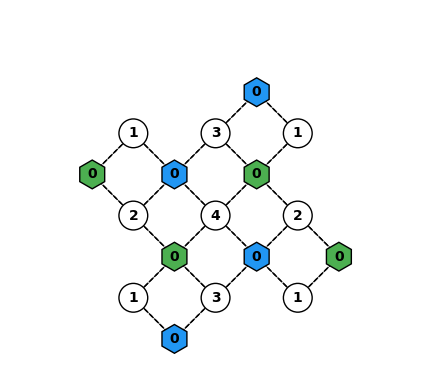

In [3]:
fig, ax = plt.subplots(dpi=100)

layout.plot(param_label="freq_group", axis=ax)
plt.tight_layout()
plt.show()

In [10]:
%%timeit
sample_params(layout, seed = 5, resist_var = 1e-2)
_ = get_collisions(layout)

156 ms ± 2.57 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Scan for distance 3

In [11]:
MAX_RES_VAR = 8e-2
NUM_RES_VARS = 20
NUM_SEEDS = 1000

RES_VARS = np.geomspace(1e-3, MAX_RES_VAR, NUM_RES_VARS)
SEEDS = np.arange(1, NUM_SEEDS + 1)

sampled_collisions = np.zeros((NUM_RES_VARS, NUM_SEEDS, 3), dtype=int)

for var_ind, res_var in enumerate(RES_VARS):
    for seed_ind, seed in enumerate(SEEDS):
        sample_params(layout, seed, res_var)
        sampled_collisions[var_ind, seed_ind] = get_collisions(layout)

In [12]:
total_collisions = sampled_collisions.sum(axis = 2)
collision_stats = sampled_collisions.sum(axis = 1)
device_yield = np.mean(total_collisions == 0, axis= 1)

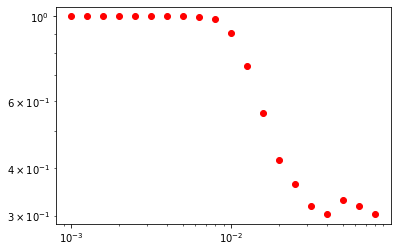

In [13]:
fig, ax = plt.subplots()

ax.scatter(RES_VARS, device_yield, color="red")
ax.set_xscale("log")
ax.set_yscale("log")

plt.show()

# Scan with distance as well

In [19]:
MAX_RES_VAR = 5e-1
NUM_RES_VARS = 20
NUM_SEEDS = 10000

DISTANCES = [3, 5, 7]
RES_VARS = np.geomspace(1e-3, MAX_RES_VAR, NUM_RES_VARS)
SEEDS = np.arange(1, NUM_SEEDS + 1)


sampled_collisions = np.zeros(
    (len(DISTANCES), NUM_RES_VARS, NUM_SEEDS, 3), dtype=int
)

for dist_ind, distance in enumerate(DISTANCES):
    layout = surface_code(distance, mixed_layout=True)
    
    set_freq_groups(layout)
    set_transmon_target_freqs(layout, GROUP_FREQS, GROUP_ANHARMS)
    set_fluxonia_target_energies(layout, target_induct_energy=1, target_joseph_energy=4)

    for var_ind, res_var in enumerate(RES_VARS):
        for seed_ind, seed in enumerate(SEEDS):
            sample_params(layout, seed, res_var)
            sampled_collisions[dist_ind, var_ind, seed_ind] = get_collisions(layout)

KeyboardInterrupt: 

In [21]:
collisions = xr.DataArray(
    sampled_collisions,
    dims = ["distance", "resist_var", "seed", "collision_type"],
    coords = dict(
        distance = DISTANCES,
        resist_var = RES_VARS,
        seed = SEEDS,
        collision_type = ["address", "cross_res", "spectator"]
    )
)

In [22]:
total_collisions = collisions.sum(dim="collision_type")
collision_stats = collisions.sum(dim="seed")

zero_collision_runs = xr.where(total_collisions == 0, 1, 0)
device_yield = zero_collision_runs.mean(dim="seed")

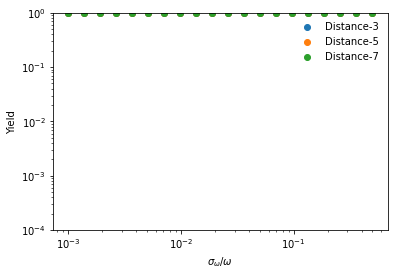

In [24]:
fig, ax = plt.subplots()

for dist in device_yield.distance.values:
    label = f"Distance-{dist}"
    ax.scatter(
        device_yield.resist_var, 
        device_yield.sel(distance=dist),
        label=label,
    )
    
ax.set_xscale("log")
ax.set_xlabel(r"$\sigma_{\omega}/\omega$")
ax.set_ylabel(r"Yield")
ax.set_yscale("log")
ax.set_ylim(1e-4, 1)
ax.legend(frameon=False)

plt.show()

In [177]:
SAVE_DATA = False

if SAVE_DATA:
    notebook_dir = Path.cwd()
    data_folder = notebook_dir / "data"
    data_folder.mkdir(parents=True, exist_ok=True)
    
    data_arr_name = f"tmon_tmob_yield_scan_dist_{*DISTANCES,}_max_var_{MAX_FREQ_VAR}_seeds_{NUM_SEEDS}.nc"
    collisions.to_netcdf(data_folder/data_arr_name)